## **TP2: Métodos** 

In [1]:
import numpy as np
import matplotlib as plt
import numpy.linalg as lng
from scipy.linalg import lu
from scipy import linalg
import networkx as nx
from scipy.stats.stats import pearsonr
import pandas as pd
import metnum as mt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Club de Karate

Leer grafos

In [2]:
def leer_karateclub(path = "../datasets/karateclub_matriz.txt"):
  M = np.zeros(34*34).reshape(34, 34)
  with open(path,'r') as file:
    # reading each line 
    i = 0
    for line in file:
      line = line.split()
      for j in range(0, len(line)):

        M[i][j] = line[j]
      i+=1
  return M

In [3]:
def leer_labels_karate(path = "../datasets/karateclub_labels.txt"):
    file = open(path,'r')
    labels = np.zeros(34)
    i = 0
    with open(path,'r') as file:
    # reading each line    
        for line in file:
            labels[i] = line
            i+=1
    return labels

Leer karate club con NetworkX

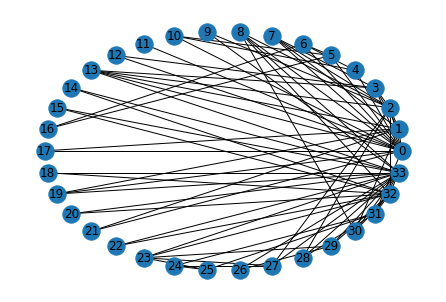

In [4]:
karate = nx.karate_club_graph()
nx.draw_circular(karate, with_labels = True)

Cargamos el grafo del club de karate

In [5]:
A = leer_karateclub()
A_labels = leer_labels_karate()

### Centralidad del autovector 

In [6]:
eigval, eigvect = mt.power_iteration(A.astype(float), 10000, 1e-10)

Matriz Laplaciana

In [7]:
L = np.zeros(34*34).reshape(34, 34)
np.fill_diagonal(L, np.sum(A, axis = 1))
L = L-A

Autovalores y Autovalores Laplaciana

In [8]:
L_eigval, L_eigvect = mt.deflation(L, 34, 10000, 1e-10)
#L_eigval, L_eigvect = np.linalg.eig(L)
#sort 
sort_labels_eigval = np.argsort(L_eigval)
L_eigval = L_eigval[sort_labels_eigval]
L_eigvect = L_eigvect[::, sort_labels_eigval]

Calculo de Correlación entre el vector resultado de cortar la red de karate con los autovectores vs el corte real 

In [9]:

A_labels = leer_labels_karate()

C = np.hstack([L_eigvect, A_labels.reshape(34,1)])

#correlation matrix 
C = abs(np.corrcoef(C.T))

corr = C[:, 34]
corr[34]=0

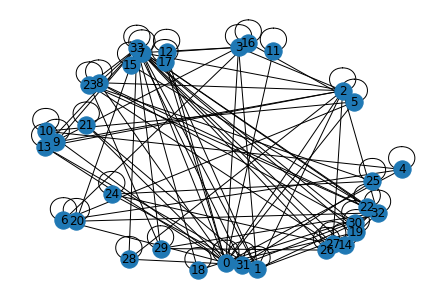

In [10]:
L_g = nx.from_numpy_array(L)
nx.draw_spring(L_g,  with_labels = True)

In [11]:
centrality = nx.eigenvector_centrality(L_g)

#sorted((v, f"{c:0.2f}") for v, c in centrality.items())

# FACEBOOK

In [12]:
feat = pd.read_csv("../datasets/ego-facebook.feat", sep=" ",  header = None)
edges_d = pd.read_csv("../datasets/ego-facebook.edges", sep=" ", header = None, names=["a", "b"])
feat = feat.rename(columns={0: "a"})
display(feat)
#Filtro feat con los nodos de edges 
edges = edges_d.values.flatten()
edges = np.unique(edges).astype(int)
edges =pd.DataFrame(edges)
edges = edges.rename(columns ={0:"a"})

feat = edges.merge(feat, on="a", how= "left")
feat = feat.sort_values(by = ["a"])

#saco los ind de los nodos 
feat_sin_ind = feat
print(feat)
feat_sin_ind.drop('a', axis = 1, inplace=True)

F_att = feat_sin_ind.to_numpy() #mat de atributos 
F_att2 = feat_sin_ind.to_numpy() 
F_att.shape

,a,1,2,3,4,5,6,7,8,9,...,310,311,312,313,314,315,316,317,318,319
0,2661,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2662,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2663,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2664,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2665,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,3432,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
788,3433,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
789,3434,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
790,3435,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


        a  1  2  3  4  5  6  7  8  9  ...  310  311  312  313  314  315  316  \
0      58  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
1     107  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
2     171  0  0  0  0  0  0  0  0  0  ...    0    0    1    0    0    0    0   
3     990  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
4    1171  0  0  0  0  0  0  0  1  0  ...    0    0    0    0    0    0    0   
..    ... .. .. .. .. .. .. .. .. ..  ...  ...  ...  ...  ...  ...  ...  ...   
781  3432  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
782  3433  0  0  0  0  0  0  1  0  0  ...    0    0    0    0    0    0    0   
783  3434  0  0  0  0  0  0  0  0  0  ...    0    0    0    0    0    0    0   
784  3435  0  0  0  0  0  0  1  0  0  ...    0    0    0    0    0    0    0   
785  3436  0  0  0  0  0  1  0  0  0  ...    0    0    0    0    0    0    0   

     317  318  319  
0      0    0    0

(786, 319)

Leer matriz de adj facebook

In [13]:
def leer_face_adj():
    ed1 = edges_d["a"]
    ed2 = edges_d["b"]
    tags_ind = sorted(list(set(edges_d["a"])))
    f = np.array(np.zeros(786*786)).reshape(786, 786)
    for i in range(0, len(ed1)):
        ind_a = tags_ind.index(ed1[i])
        ind_b = tags_ind.index(ed2[i])
        f[ind_a][ind_b] = 1
        f[ind_b][ind_a] = 1
    return f

### Matriz de facebook

In [14]:
face = leer_face_adj()
face.shape

(786, 786)

# Matriz de Similaridad de facebook

In [15]:
mat_similaridad = F_att @ F_att.T

Todos los posibles umbrales

In [16]:
mat_similaridad_valores = np.unique(mat_similaridad.flatten())
print(mat_similaridad_valores)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


Analizamos la distribución de los valores en la matriz de similaridad con un histograma

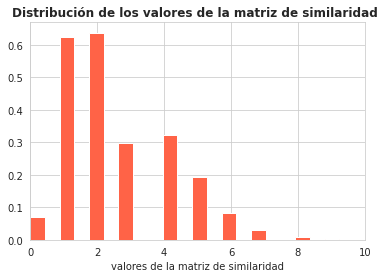

In [17]:
mat_simi_flatten = mat_similaridad.flatten()
plt.hist(mat_simi_flatten, 50, density= True, color = "tomato")
plt.title("Distribución de los valores de la matriz de similaridad ", fontweight="bold")
plt.xlim(0, 10)
plt.xlabel("valores de la matriz de similaridad")
plt.show()

Vemos los valores correlación entre la matriz de atributos flatten y la matriz de similaridad filtrada flatten para todos los umbrales posibles

In [18]:
mat_similaridad_valores = np.unique(mat_similaridad.flatten())
face_mat_adj = face.flatten()
cor1 = []
for i in range(0, 21):
    mat_similaridad_index = mat_similaridad > i
    mat_similaridad_index = mat_similaridad_index.astype(int)
    mat_simi_filt = mat_similaridad_index.flatten()
    cor1.append(np.corrcoef(mat_simi_filt,  face_mat_adj)[0,1])
cor1 = [abs(i) for i in cor1]
#print(cor1)
print("max correlación", max(cor1))

max correlación 0.10804842659646784


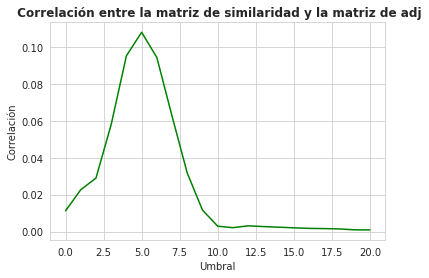

In [19]:
plt.plot(cor1, color = "green")
plt.title(" Correlación entre la matriz de similaridad y la matriz de adj",  fontweight="bold")
plt.xlabel("Umbral")
plt.ylabel("Correlación")
plt.show()

Ahora vemos la correlación entre los autovalores de la matriz de similaridad y los autovalores de facebook 

In [20]:
mat_similaridad_valores = np.unique(mat_similaridad.flatten())
face_mat_adj = face
#print(np.allclose(face_mat_adj, face_mat_adj.T))
eigvals_face = sorted(linalg.eigvals(face_mat_adj))

cor_autoval = []
for i in range(0, 21):
    mat_similaridad_index = mat_similaridad > i
    mat_similaridad_index = mat_similaridad_index.astype(int)
    
    eigvals_simi = linalg.eigvals( mat_similaridad_index)
    eigvals_simi = sorted(eigvals_simi)
    
    cor_autoval.append(np.corrcoef(np.real(eigvals_simi), np.real(eigvals_face) )[0,1])
print("max correlación", max(cor_autoval))


max correlación 0.9595908617203155


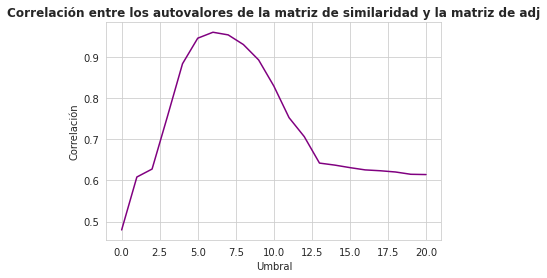

In [21]:
plt.plot(cor_autoval, color = "purple")
plt.title("Correlación entre los autovalores de la matriz de similaridad y la matriz de adj", fontweight="bold")
plt.xlabel("Umbral")
plt.ylabel("Correlación")
plt.show()

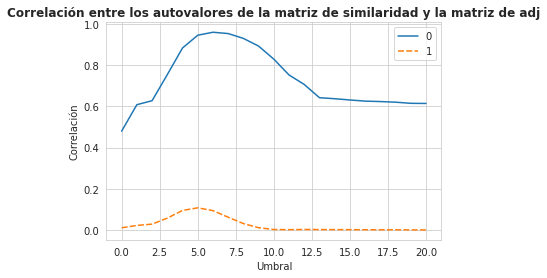

In [22]:
#Este no me gusta pq las escalas son muy distintas 
sns.lineplot([cor_autoval, cor1])
plt.title("Correlación entre los autovalores de la matriz de similaridad y la matriz de adj", fontweight="bold")
plt.xlabel("Umbral")
plt.ylabel("Correlación")
plt.show()

# PCA 

### Matriz de covarianza 

In [23]:
#probe func
A = np.array([1 ,2, 3, 4, 5, 6]).reshape(3,2)
print(A)
print(np.mean(A, axis = 0))
mean = np.mean(A, axis = 0)

B= np.tile(mean, 3).reshape(3, 2)
print((A-B)/2)

[[1 2]
 [3 4]
 [5 6]]
[3. 4.]
[[-1. -1.]
 [ 0.  0.]
 [ 1.  1.]]


In [24]:
#Creo que lo del mean anda bien 
m, n = F_att2.shape 

X = F_att2 - F_att2.mean(0)
print(X.shape)
Cov = X.T @ X / m

##chequeo que es sim 
np.allclose(Cov, Cov.T)


(786, 319)


True

In [25]:
#C_eigval, C_eigvect = mt.deflation(Cov, 34, 10000, 1e-10)
C_eigval, C_eigvect = np.linalg.eig(Cov)
C_eigval = np.real(C_eigval)
C_eigvect = np.real(C_eigvect)
#sort 
sort_labels_eigval = np.argsort(C_eigval)
C_eigval = C_eigval[sort_labels_eigval]
C_eigvect = C_eigvect[::, sort_labels_eigval]

C_eigval

array([-8.31992916e-19, -8.31992916e-19, -4.19290710e-19, -1.85756586e-19,
       -1.85756586e-19, -5.28441752e-20, -5.28441752e-20,  2.79898308e-19,
        5.79298006e-19,  3.40494613e-17,  8.45321741e-05,  1.05439646e-04,
        1.11493587e-04,  1.39152760e-04,  1.51640239e-04,  1.79703935e-04,
        2.03658405e-04,  2.12695218e-04,  2.27795632e-04,  2.50492643e-04,
        2.70138603e-04,  2.73763820e-04,  2.91533288e-04,  3.08056952e-04,
        3.21934118e-04,  3.43621536e-04,  3.59209630e-04,  3.74218292e-04,
        4.06040713e-04,  4.16769701e-04,  4.39596691e-04,  4.57739368e-04,
        4.66937640e-04,  4.74685945e-04,  5.05081061e-04,  5.26546691e-04,
        5.44528374e-04,  5.63332916e-04,  5.72949943e-04,  5.90333763e-04,
        6.23096804e-04,  6.31224798e-04,  6.63024546e-04,  6.66657576e-04,
        6.86442583e-04,  7.05456086e-04,  7.44337632e-04,  7.71714326e-04,
        7.79819169e-04,  8.25139071e-04,  8.47154503e-04,  8.66858001e-04,
        8.78613602e-04,  

In [26]:
V = C_eigvect
D = np.zeros(786*319).reshape(786,319)
np.fill_diagonal(D, C_eigval)
print(D.shape)
V.shape

(786, 319)


(319, 319)

Ahora tomo k y veo las componentes principales 
$ k\_com \in \real^{319x50} F\_att2 \in \real^{786x50}$ 

(100, 319)
(786, 319)


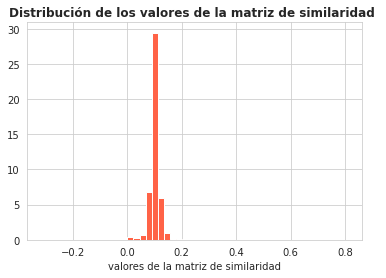

In [27]:
k = 100
k_comp = V[: , 0:k ]
print(k_comp.T.shape)
print(F_att2.shape)

tranformados = k_comp.T @ F_att2.T
mat_similaridad = tranformados.T @ tranformados

mat_simi_flatten = mat_similaridad.flatten()
plt.hist(mat_simi_flatten, 50, density= True, color = "tomato")
plt.title("Distribución de los valores de la matriz de similaridad ", fontweight="bold")
#plt.xlim(-0.05,  0.05)
plt.xlabel("valores de la matriz de similaridad")
plt.show()

In [28]:
u = np.arange(0, 0.02, 0.001)
u.shape

(20,)

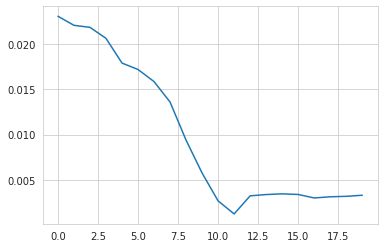

In [29]:
face_mat_adj = face.flatten()
cor1 = []

for j in range(0, len(u)): 
    U = (mat_similaridad > u[j])
    
    U = U.astype(int)
    
    mat_simi_filt = U.flatten()
    cor1.append(np.corrcoef(mat_simi_filt,  face_mat_adj)[0,1])
    cor1 = [abs(i) for i in cor1]
#print(cor1)
plt.plot(cor1)

(319, 319)
(786, 319)


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


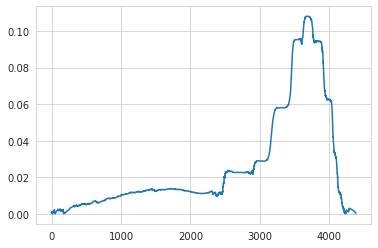

In [31]:
k = 319
k_comp = V[: , 0:k ]
print(k_comp.T.shape)
print(F_att2.shape)

tranformados = k_comp.T @ F_att2.T
mat_similaridad = tranformados.T @ tranformados

u = np.unique(mat_similaridad.flatten())
face_mat_adj = face.flatten()
cor1 = []

for j in range(0, len(u)): 
    U = (mat_similaridad > u[j])
    
    U = U.astype(int)
    
    mat_simi_filt = U.flatten()
    cor1.append(np.corrcoef(mat_simi_filt,  face_mat_adj)[0,1])
    cor1 = [abs(i) for i in cor1]
#print(cor1)
plt.plot(cor1)

In [33]:
k = 100
k_comp = V[: , 0:k ]
print(k_comp.T.shape)
print(F_att2.shape)

tranformados = k_comp.T @ F_att2.T
mat_similaridad = tranformados.T @ tranformados

u = np.unique(mat_similaridad.flatten())
face_mat_adj = face.flatten()
cor1 = []
print(len(u))
for j in range(0, len(u)): 
    U = (mat_similaridad > u[j])
    
    U = U.astype(int)
    
    mat_simi_filt = U.flatten()
    cor1.append(np.corrcoef(mat_simi_filt,  face_mat_adj)[0,1])
    cor1 = [abs(i) for i in cor1]
#print(cor1)
plt.plot(cor1)

(100, 319)
(786, 319)
192510


KeyboardInterrupt: 